In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import os
import sys
import random
import time
import matplotlib
from matplotlib import colors as c
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [3]:
def data_init(traj_label, past_traj_data, future_traj_data, traj_weights):
    assert len(future_traj_data)==len(traj_label)
    
    # skip the first t0 data
    past_data = past_traj_data
    future_data = future_traj_data
    label = traj_label
    
    # data shape
    data_shape = past_data.shape[1:]
    
    n_data = len(past_data)
    
    # 90% random test/train split
    p = np.random.permutation(n_data)
    past_data = past_data[p]
    future_data = future_data[p]
    label = label[p]
    
    past_data_train = past_data[0: (9 * n_data) // 10]
    past_data_test = past_data[(9 * n_data) // 10:]
    
    future_data_train = future_data[0: (9 * n_data) // 10]
    future_data_test = future_data[(9 * n_data) // 10:]
    
    label_train = label[0: (9 * n_data) // 10]
    label_test = label[(9 * n_data) // 10:]
    
    if traj_weights != None:
        assert len(traj_data)==len(traj_weights)
        weights = traj_weights[t0:(len(traj_data)-dt)]
        weights = weights[p]
        weights_train = weights[0: (9 * n_data) // 10]
        weights_test = weights[(9 * n_data) // 10:]
    else:
        weights_train = None
        weights_test = None
    
    return data_shape, past_data_train, future_data_train, label_train, weights_train,\
        past_data_test, future_data_test, label_test, weights_test

# Loss function
# ------------------------------------------------------------------------------

def calculate_loss(IB, data_inputs, data_targets, data_weights, beta=1.0):
    
    # pass through VAE
    outputs, z_sample, z_mean, z_logvar = IB.forward(data_inputs)
    
    # KL Divergence
    log_p = IB.log_p(z_sample)
    log_q = -0.5 * torch.sum(z_logvar + torch.pow(z_sample-z_mean, 2)
                             /torch.exp(z_logvar), dim=1)
    
    if data_weights == None:
        # Reconstruction loss is cross-entropy
        reconstruction_error = torch.mean(torch.sum(-data_targets*outputs, dim=1))
        
        # KL Divergence
        kl_loss = torch.mean(log_q-log_p)
        
    else:
        # Reconstruction loss is cross-entropy
        # reweighed
        reconstruction_error = torch.mean(data_weights*torch.sum(-data_targets*outputs, dim=1))
        
        # KL Divergence
        kl_loss = torch.mean(data_weights*(log_q-log_p))
        
    
    loss = reconstruction_error + beta*kl_loss

    return loss, reconstruction_error.float(), kl_loss.float()


# Train and test model
# ------------------------------------------------------------------------------

def sample_minibatch(past_data, data_labels, data_weights, indices, device):
    sample_past_data = past_data[indices].to(device)
    sample_data_labels = data_labels[indices].to(device)
    
    if data_weights == None:
        sample_data_weights = None
    else:
        sample_data_weights = data_weights[indices].to(device)
    
    
    return sample_past_data, sample_data_labels, sample_data_weights


def train(IB, beta, train_past_data, train_future_data, init_train_data_labels, train_data_weights, \
          test_past_data, test_future_data, init_test_data_labels, test_data_weights, \
              learning_rate, lr_scheduler_step_size, lr_scheduler_gamma, batch_size, threshold, patience, refinements, log_interval, device, index):
    IB.train()
    
    step = 0
    start = time.time()
    
    train_data_labels = init_train_data_labels
    test_data_labels = init_test_data_labels

    update_times = 0
    unchanged_epochs = 0
    epoch = 0

    # initial state population
    state_population0 = torch.sum(train_data_labels,dim=0).float()/train_data_labels.shape[0]

    # generate the optimizer and scheduler
    optimizer = torch.optim.Adam(IB.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)

    while True:
        
        train_permutation = torch.randperm(len(train_past_data))
        test_permutation = torch.randperm(len(test_past_data))
        
        
        for i in range(0, len(train_past_data), batch_size):
            step += 1
            
            if i+batch_size>len(train_past_data):
                break
            
            train_indices = train_permutation[i:i+batch_size]
            
            batch_inputs, batch_outputs, batch_weights = sample_minibatch(train_past_data, train_data_labels, \
                                                                       train_data_weights, train_indices, device)
                    
            loss, reconstruction_error, kl_loss= calculate_loss(IB, batch_inputs, \
                                                                batch_outputs, batch_weights, beta)
            
            # Stop if NaN is obtained
            if(torch.isnan(loss).any()):
                return True
            
            outputs, z_sample, z_mean, z_logvar = IB.forward(batch_inputs)
            spa_loss = z_mean.pow(2).sum().div( z_mean.size(0) )
            spa_loss_sig = 1/ (1+torch.exp(-(spa_loss-10)))

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            spa_loss_sig.backward()
            optimizer.step()
            
            if step % 500 == 0:
                with torch.no_grad():
                    
                    batch_inputs, batch_outputs, batch_weights = sample_minibatch(train_past_data, train_data_labels, \
                                                                               train_data_weights, train_indices, device)
                            
                    loss, reconstruction_error, kl_loss= calculate_loss(IB, batch_inputs, \
                                                                        batch_outputs, batch_weights, beta)
                    train_time = time.time() - start
                    
                    outputs, z_sample, z_mean, z_logvar = IB.forward(batch_inputs)
                    spa_loss = z_mean.pow(2).sum().div( z_mean.size(0) )
                    spa_loss_sig = 1/ (1+torch.exp(-(spa_loss-10)))

                    print("Iteration %i:\tTime %f s\nLoss (train) %f\tKL loss (train): %f\n"
                        "Reconstruction loss (train) %f\t Spatial loss %f" % (
                            step, train_time, loss, kl_loss, reconstruction_error,spa_loss_sig))
                    
                    j=i%len(test_permutation)
                    
                    
                    
                    test_indices = test_permutation[j:j+batch_size]
                    
                    batch_inputs, batch_outputs, batch_weights = sample_minibatch(test_past_data, test_data_labels, \
                                                                               test_data_weights, test_indices, device)
                    
                    loss, reconstruction_error, kl_loss = calculate_loss(IB, batch_inputs, \
                                                                         batch_outputs, batch_weights, beta)

                    train_time = time.time() - start
                    print("Loss (test) %f\tKL loss (test): %f\n"
                       "Reconstruction loss (test) %f" % (
                           loss, kl_loss, reconstruction_error))
                    

        epoch+=1
        
        # check convergence
        new_train_data_labels = IB.update_labels(train_future_data, batch_size)

        # save the state population
        state_population = torch.sum(new_train_data_labels,dim=0).float()/new_train_data_labels.shape[0]

        print(state_population)

        # print the state population change
        state_population_change = torch.sqrt(torch.square(state_population-state_population0).sum())
        
        print('State population change=%f'%state_population_change)

        # update state_population
        state_population0 = state_population

        scheduler.step()
        if scheduler.gamma < 1:
            print("Update lr to %f"%(optimizer.param_groups[0]['lr']))

        # check whether the change of the state population is smaller than the threshold
        if state_population_change < threshold:
            unchanged_epochs += 1
            
            if unchanged_epochs > patience:

                # check whether only one state is found
                if torch.sum(state_population>0)<2:
                    print("Only one metastable state is found!")
                    break

                # Stop only if update_times >= refinements
                if IB.UpdateLabel and update_times < refinements:
                    
                    train_data_labels = new_train_data_labels
                    test_data_labels = IB.update_labels(test_future_data, batch_size)
    
                    update_times+=1
                    print("Update %d\n"%(update_times))
                    
                    # reset epoch and unchanged_epochs
                    epoch = 0
                    unchanged_epochs = 0

                    # reset the representative-inputs
                    representative_inputs = IB.estimatate_representative_inputs(train_past_data, train_data_weights, batch_size)
                    IB.reset_representative(representative_inputs.to(device))
    
                    # reset the optimizer and scheduler
                    optimizer = torch.optim.Adam(IB.parameters(), lr=learning_rate)

                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
                    
                else:
                    break

        else:
            unchanged_epochs = 0

        print("Epoch: %d\n"%(epoch))

    # output the saving path
    total_training_time = time.time() - start
    print("Total training time: %f" % total_training_time)

    return False

def output_final_result(IB, device, train_past_data, train_future_data, train_data_labels, train_data_weights, \
                        test_past_data, test_future_data, test_data_labels, test_data_weights, batch_size, \
                             dt, beta, learning_rate, index=0):
    
    with torch.no_grad():
        
        # label update
        if IB.UpdateLabel:
            train_data_labels = IB.update_labels(train_future_data, batch_size)
            test_data_labels = IB.update_labels(test_future_data, batch_size)
        
        final_result = []
        # output the result
        
        loss, reconstruction_error, kl_loss= [0 for i in range(3)]
        
        for i in range(0, len(train_past_data), batch_size):
            batch_inputs, batch_outputs, batch_weights = sample_minibatch(train_past_data, train_data_labels, train_data_weights, \
                                                                       range(i,min(i+batch_size,len(train_past_data))), IB.device)
            loss1, reconstruction_error1, kl_loss1 = calculate_loss(IB, batch_inputs, batch_outputs, \
                                                                    batch_weights, beta)
            loss += loss1*len(batch_inputs)
            reconstruction_error += reconstruction_error1*len(batch_inputs)
            kl_loss += kl_loss1*len(batch_inputs)
            
        
        # output the result
        loss/=len(train_past_data)
        reconstruction_error/=len(train_past_data)
        kl_loss/=len(train_past_data)
                
        final_result += [loss.data.cpu().numpy(), reconstruction_error.cpu().data.numpy(), kl_loss.cpu().data.numpy()]
        print("Final: %d\nLoss (train) %f\tKL loss (train): %f\n"
                    "Reconstruction loss (train) %f" % (index, loss, kl_loss, reconstruction_error))
       
    
        loss, reconstruction_error, kl_loss = [0 for i in range(3)]
        
        for i in range(0, len(test_past_data), batch_size):
            batch_inputs, batch_outputs, batch_weights = sample_minibatch(test_past_data, test_data_labels, test_data_weights, \
                                                                                         range(i,min(i+batch_size,len(test_past_data))), IB.device)
            loss1, reconstruction_error1, kl_loss1 = calculate_loss(IB, batch_inputs, batch_outputs, \
                                                                   batch_weights, beta)
            loss += loss1*len(batch_inputs)
            reconstruction_error += reconstruction_error1*len(batch_inputs)
            kl_loss += kl_loss1*len(batch_inputs)
            
        
        # output the result
        loss/=len(test_past_data)
        reconstruction_error/=len(test_past_data)
        kl_loss/=len(test_past_data)
        
        final_result += [loss.cpu().data.numpy(), reconstruction_error.cpu().data.numpy(), kl_loss.cpu().data.numpy()]
        print("Loss (test) %f\tKL loss (train): %f\n"
            "Reconstruction loss (test) %f"% (loss, kl_loss, reconstruction_error))

In [4]:
class SPIB(nn.Module):

    def __init__(self, encoder_type, z_dim, output_dim, data_shape, device, UpdateLabel= False, neuron_num1=128, 
                 neuron_num2=128):
        
        super(SPIB, self).__init__()
        if encoder_type == 'Nonlinear':
            self.encoder_type = 'Nonlinear'
        else:
            self.encoder_type = 'Linear'

        self.z_dim = z_dim
        self.output_dim = output_dim
        
        self.neuron_num1 = neuron_num1
        self.neuron_num2 = neuron_num2
        
        self.data_shape = data_shape
        
        self.UpdateLabel = UpdateLabel
        
        self.eps = 1e-10
        self.device = device
        
        

        # representative-inputs
        self.representative_dim = output_dim

        # torch buffer, these variables will not be trained
        self.representative_inputs = torch.eye(self.output_dim, np.prod(self.data_shape), device=device, requires_grad=False)
        
        # create an idle input for calling representative-weights
        # torch buffer, these variables will not be trained
        self.idle_input = torch.eye(self.output_dim, self.output_dim, device=device, requires_grad=False)

        # representative weights
        self.representative_weights = nn.Sequential(
            nn.Linear(self.output_dim, 1, bias=False),
            nn.Softmax(dim=0))
        
        self.encoder = self._encoder_init()

        if self.encoder_type == 'Nonlinear': 
            self.encoder_mean = nn.Linear(self.neuron_num1, self.z_dim)
        else:
            self.encoder_mean = nn.Linear(np.prod(self.data_shape), self.z_dim)
        
        # Note: encoder_type = 'Linear' only means that z_mean is a linear combination of the input OPs, 
        # the log_var is always obtained through a nonlinear NN

        # enforce log_var in the range of [-10, 0]
        self.encoder_logvar = nn.Sequential(
            nn.Linear(self.neuron_num1, self.z_dim),
            nn.Sigmoid())
        
        self.decoder = self._decoder_init()
        
    def _encoder_init(self):
        
        modules = [nn.Linear(np.prod(self.data_shape), self.neuron_num1)]
        modules += [nn.ReLU()]
        for _ in range(1):
            modules += [nn.Linear(self.neuron_num1, self.neuron_num1)]
            modules += [nn.ReLU()]
        
        return nn.Sequential(*modules)
    
    def _decoder_init(self):
        # cross-entropy MLP decoder
        # output the probability of future state
        modules = [nn.Linear(self.z_dim, self.neuron_num2)]
        modules += [nn.ReLU()]
        for _ in range(1):
            modules += [nn.Linear(self.neuron_num2, self.neuron_num2)]
            modules += [nn.ReLU()]
        
        modules += [nn.Linear(self.neuron_num2, self.output_dim)]
        modules += [nn.LogSoftmax(dim=1)]
        
        return nn.Sequential(*modules)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def encode(self, inputs):
        enc = self.encoder(inputs)
        
        if self.encoder_type == 'Nonlinear': 
            z_mean = self.encoder_mean(enc)
        else:
            z_mean = self.encoder_mean(inputs)

        # Note: encoder_type = 'Linear' only means that z_mean is a linear combination of the input OPs, 
        # the log_var is always obtained through a nonlinear NN
        
        # enforce log_var in the range of [-10, 0]
        z_logvar = -10*self.encoder_logvar(enc)
        
        return z_mean, z_logvar
    
    def forward(self, data):
        inputs = torch.flatten(data, start_dim=1)
        
        z_mean, z_logvar = self.encode(inputs)
        
        z_sample = self.reparameterize(z_mean, z_logvar)
        
        outputs = self.decoder(z_sample)
        
        return outputs, z_sample, z_mean, z_logvar
    
    def log_p (self, z, sum_up=True):
        # get representative_z - representative_dim * z_dim
        representative_z_mean, representative_z_logvar = self.get_representative_z()
        # get representative weights - representative_dim * 1
        w = self.representative_weights(self.idle_input)
        # w = 0.5*torch.ones((2,1)).to(self.device)
        
        # expand z - batch_size * z_dim
        z_expand = z.unsqueeze(1)
        
        representative_mean = representative_z_mean.unsqueeze(0)
        representative_logvar = representative_z_logvar.unsqueeze(0)
        
        # representative log_q
        representative_log_q = -0.5 * torch.sum(representative_logvar + torch.pow(z_expand-representative_mean, 2)
                                        / torch.exp(representative_logvar), dim=2 )
        
        if sum_up:
            log_p = torch.sum(torch.log(torch.exp(representative_log_q)@w + self.eps), dim=1)
        else:
            log_p = torch.log(torch.exp(representative_log_q)*w.T + self.eps)  
            
        return log_p
        
    # the prior
    def get_representative_z(self):
        # calculate representative_means
        # with torch.no_grad():
        X = self.representative_inputs

        # calculate representative_z
        representative_z_mean, representative_z_logvar = self.encode(X)  # C x M

        return representative_z_mean, representative_z_logvar

    def reset_representative(self, representative_inputs):
        
        # reset the nuber of representative inputs   
        self.representative_dim = representative_inputs.shape[0]        
        
        # reset representative weights
        self.idle_input = torch.eye(self.representative_dim, self.representative_dim, device=self.device, requires_grad=False)

        self.representative_weights = nn.Sequential(
            nn.Linear(self.representative_dim, 1, bias=False),
            nn.Softmax(dim=0))
        self.representative_weights[0].weight = nn.Parameter(torch.ones([1, self.representative_dim], device=self.device))
        
        # reset representative inputs
        self.representative_inputs = representative_inputs.clone().detach()
        
    @torch.no_grad()
    def init_representative_inputs(self, inputs, labels):
        state_population = labels.sum(dim=0).cpu()
        
        # randomly pick up one sample from each initlal state as the initial guess of representative-inputs
        representative_inputs=[]
        
        for i in range(state_population.shape[-1]):
            if state_population[i]>0:
                index = np.random.randint(0,state_population[i])
                representative_inputs+=[inputs[labels[:,i].bool()][index].reshape(1,-1)]
                # print(index)
        
        representative_inputs = torch.cat(representative_inputs, dim=0)

        self.reset_representative(representative_inputs.to(self.device))
            
        return representative_inputs

    @torch.no_grad()
    def estimatate_representative_inputs(self, inputs, bias, batch_size):
        prediction = []
        mean_rep = []
        for i in range(0, len(inputs), batch_size):
            batch_inputs = inputs[i:i+batch_size].to(self.device)
        
            # pass through VAE
            z_mean, z_logvar = self.encode(batch_inputs)        
            log_prediction = self.decoder(z_mean)
            
            # label = p/Z
            prediction += [log_prediction.exp()]
            
            mean_rep += [z_mean]
        
        prediction = torch.cat(prediction, dim=0)
        mean_rep = torch.cat(mean_rep, dim=0)
        
        max_pos = prediction.argmax(1)
        labels = F.one_hot(max_pos, num_classes=self.output_dim)
        
        state_population = labels.sum(dim=0)
        
        # save new guess of representative-inputs
        representative_inputs=[]
        
        for i in range(state_population.shape[-1]):
            if state_population[i]>0:
                if bias == None:
                    center_z = ((mean_rep[labels[:,i].bool()]).mean(dim=0)).reshape(1,-1)
                else:
                    weights = bias[labels[:,i].bool()].reshape(-1,1)
                    center_z = ((weights*mean_rep[labels[:,i].bool()]).sum(dim=0)/weights.sum()).reshape(1,-1)
                
                # find the one cloest to center_z as representative-inputs
                dist=torch.square(mean_rep-center_z).sum(dim=-1)                
                index = torch.argmin(dist)
                representative_inputs+=[inputs[index].reshape(1,-1)]
                # print(index)
        
        representative_inputs = torch.cat(representative_inputs, dim=0)
            
        return representative_inputs
            
    @torch.no_grad()
    def update_labels(self, inputs, batch_size):
        if self.UpdateLabel:
            labels = []
            
            for i in range(0, len(inputs), batch_size):
                batch_inputs = inputs[i:i+batch_size].to(self.device)
            
                # pass through VAE
                z_mean, z_logvar = self.encode(batch_inputs)        
                log_prediction = self.decoder(z_mean)
                
                # label = p/Z
                labels += [log_prediction.exp()]
            
            labels = torch.cat(labels, dim=0)
            max_pos = labels.argmax(1)
            labels = F.one_hot(max_pos, num_classes=self.output_dim)
            
            return labels
    
    @torch.no_grad()
    def save_representative_parameters(self, path, index=0):
        
        # output representative centers
        representative_path = path + '_representative_inputs' + str(index) + '.npy'
        representative_weight_path = path + '_representative_weight' + str(index) + '.npy'
        representative_z_mean_path = path + '_representative_z_mean' + str(index) + '.npy'
        representative_z_logvar_path = path + '_representative_z_logvar' + str(index) + '.npy'
        os.makedirs(os.path.dirname(representative_path), exist_ok=True)
        
        np.save(representative_path, self.representative_inputs.cpu().data.numpy())
        np.save(representative_weight_path, self.representative_weights(self.idle_input).cpu().data.numpy())
        
        representative_z_mean, representative_z_logvar = self.get_representative_z()
        np.save(representative_z_mean_path, representative_z_mean.cpu().data.numpy())
        np.save(representative_z_logvar_path, representative_z_logvar.cpu().data.numpy())
        
    @torch.no_grad()
    def save_traj_results(self, inputs, batch_size):
        all_prediction=[] 
        all_z_sample=[] 
        all_z_mean=[] 
        
        for i in range(0, len(inputs), batch_size):
            
            batch_inputs = inputs[i:i+batch_size].to(self.device)
        
            # pass through VAE
            z_mean, z_logvar = self.encode(batch_inputs)
            z_sample = self.reparameterize(z_mean, z_logvar)
        
            log_prediction = self.decoder(z_mean)
            
            all_prediction+=[log_prediction.exp().cpu()]
            all_z_sample+=[z_sample.cpu()]
            all_z_mean+=[z_mean.cpu()]
            
        all_prediction = torch.cat(all_prediction, dim=0)
        all_z_sample = torch.cat(all_z_sample, dim=0)
        all_z_mean = torch.cat(all_z_mean, dim=0)
        
        max_pos = all_prediction.argmax(1)
        labels = F.one_hot(max_pos, num_classes=self.output_dim)
        
        # save the fractional population of different states
        population = torch.sum(labels,dim=0).float()/len(inputs)
        return all_z_mean, all_z_sample, labels, population

In [5]:
class SPIB_zmean(nn.Module):

    def __init__(self, encoder_type, z_dim, output_dim, data_shape, device, UpdateLabel= False, neuron_num1=128, 
                 neuron_num2=128):
        
        super(SPIB_zmean, self).__init__()
        if encoder_type == 'Nonlinear':
            self.encoder_type = 'Nonlinear'
        else:
            self.encoder_type = 'Linear'

        self.z_dim = z_dim
        self.output_dim = output_dim
        
        self.neuron_num1 = neuron_num1
        self.neuron_num2 = neuron_num2
        
        self.data_shape = data_shape
        
        self.UpdateLabel = UpdateLabel
        
        self.eps = 1e-10
        self.device = device
        
        
        self.encoder = self._encoder_init()

        if self.encoder_type == 'Nonlinear': 
            self.encoder_mean = nn.Linear(self.neuron_num1, self.z_dim)
        else:
            self.encoder_mean = nn.Linear(np.prod(self.data_shape), self.z_dim)

                
    def _encoder_init(self):
        
        modules = [nn.Linear(np.prod(self.data_shape), self.neuron_num1)]
        modules += [nn.ReLU()]
        for _ in range(1):
            modules += [nn.Linear(self.neuron_num1, self.neuron_num1)]
            modules += [nn.ReLU()]
        
        return nn.Sequential(*modules)
    

    
    def encode(self, inputs):
        enc = self.encoder(inputs)
        
        if self.encoder_type == 'Nonlinear': 
            z_mean = self.encoder_mean(enc)
        else:
            z_mean = self.encoder_mean(inputs)
        
        return z_mean
    
    def forward(self, data):
        inputs = torch.flatten(data, start_dim=1)
        
        z_mean = self.encode(inputs)
        
        return z_mean

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default_device = torch.device("cpu")

t0 = 0
RC_dim = 2
encoder_type = 'Nonlinear'
neuron_num1 = 32
neuron_num2 = 32
batch_size = 2000
threshold = 0.05
patience = 2
refinements = 15
log_interval = 10000
lr_scheduler_step_size = 1
lr_scheduler_gamma = 1
learning_rate = 0.001
beta = 0.0001

#dcom = np.loadtxt('dxy_all.dat')
#initial_label_np = np.loadtxt('label_all.dat')

#traj_labels = torch.from_numpy(initial_label_np).float().to(device)

traj_data_np = np.loadtxt('data_all.dat')
traj_data = torch.from_numpy(traj_data_np).float().to(device)

initial_label_dt = np.loadtxt('label_all2.dat')
traj_labels_dt = torch.from_numpy(initial_label_dt).float().to(device)

output_dim = initial_label_dt.shape[1]

past_traj_data = np.loadtxt('past_data_all2.dat')
past_traj_data = torch.from_numpy(past_traj_data).float().to(device)

future_traj_data = np.loadtxt('future_data_all2.dat')
future_traj_data = torch.from_numpy(future_traj_data).float().to(device)

traj_weights = None

seed = 0
UpdateLabel = True

In [22]:
data_shape, train_past_data, train_future_data, train_data_labels, train_data_weights, \
        test_past_data, test_future_data, test_data_labels, test_data_weights = \
            data_init(traj_labels_dt, past_traj_data, future_traj_data, traj_weights)

IB = SPIB(encoder_type, RC_dim, output_dim, data_shape, device, \
                   UpdateLabel, neuron_num1, neuron_num2)
IB.to(device)

SPIB(
  (representative_weights): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=False)
    (1): Softmax(dim=0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (encoder_mean): Linear(in_features=32, out_features=2, bias=True)
  (encoder_logvar): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [23]:
IB.init_representative_inputs(train_past_data, train_data_labels)
train_result = train(IB, beta, train_past_data, train_future_data, \
                                       train_data_labels, train_data_weights, test_past_data, test_future_data, \
                                           test_data_labels, test_data_weights, learning_rate, lr_scheduler_step_size, lr_scheduler_gamma,\
                                               batch_size, threshold, patience, refinements, \
                                                   log_interval, device, seed)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])
State population change=0.840517
Epoch: 1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])
State population change=0.000000
Epoch: 2

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])
State population change=0.000000
Epoch: 3

tensor([0.0000, 0.0000, 0.2399, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7372, 0.0000, 0.0000, 0.0000,
        0.0229, 0.0000])
State population change=0.356509
Epoch: 4

tensor([0.0000, 0.0000, 0.2593, 0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5614, 0.0000, 0.0000, 0.0000,
        0.1767, 0.0000])
State population change=0.234381
Epoch: 5

tensor([0.0000, 0.0000, 0.1714, 0.0812, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.00

tensor([0.0000, 0.0000, 0.1319, 0.1331, 0.0000, 0.0000, 0.0000, 0.2072, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3266, 0.0000, 0.0000, 0.0000,
        0.2013, 0.0000])
State population change=0.002062
Update 9

Epoch: 0

tensor([0.0000, 0.0000, 0.1319, 0.1338, 0.0000, 0.0000, 0.0000, 0.2124, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3204, 0.0000, 0.0000, 0.0000,
        0.2015, 0.0000])
State population change=0.008080
Epoch: 1

tensor([0.0000, 0.0000, 0.1319, 0.1331, 0.0000, 0.0000, 0.0000, 0.2091, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3246, 0.0000, 0.0000, 0.0000,
        0.2013, 0.0000])
State population change=0.005381
Epoch: 2

tensor([0.0000, 0.0000, 0.1319, 0.1331, 0.0000, 0.0000, 0.0000, 0.2077, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3260, 0.0000, 0.0000, 0.0000,
        0.2013, 0.0000])
State population change=0.001976
Update 10

Epoch: 0

tensor([0.0000, 0.0000, 0.1319, 0.1333, 0.0000, 0.0000, 0.0000, 0.2

In [24]:
output_final_result(IB, device, train_past_data, train_future_data, train_data_labels, train_data_weights, \
                                      test_past_data, test_future_data, test_data_labels, test_data_weights, batch_size, \
                                      beta, learning_rate, seed)
final_zmean, final_zsample,final_labels, final_population = IB.save_traj_results(traj_data, batch_size)

Final: 0
Loss (train) 0.035763	KL loss (train): 18.591139
Reconstruction loss (train) 0.017172
Loss (test) 0.038869	KL loss (train): 18.697092
Reconstruction loss (test) 0.020172


In [25]:
#Save results
np.savetxt("final_zmean_spib.dat", final_zmean.detach().numpy(),fmt='%7.6f')
np.savetxt("final_labels_spib.dat", final_labels.detach().numpy(),fmt='%i')

Text(0, 0.5, 'CV2')

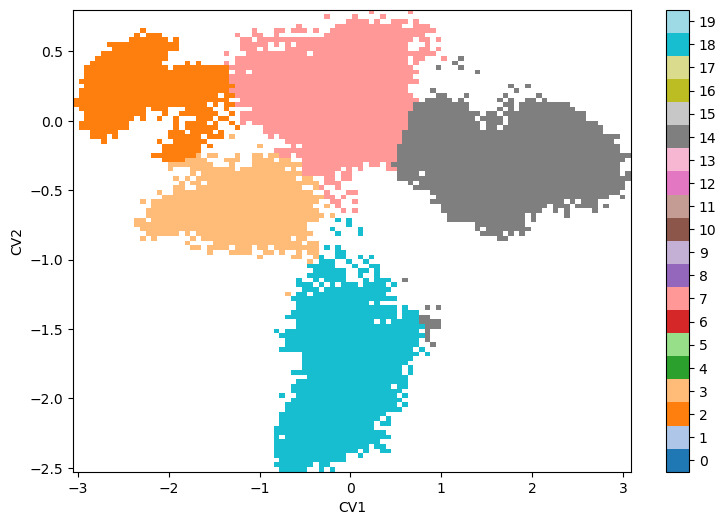

In [26]:
data= final_zmean.detach().numpy()
labels=final_labels.detach().numpy()

hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.shape[1]
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]
    
label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:20])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)


plt.xlabel("CV1")
plt.ylabel("CV2")

In [39]:
#save model
model_name = "model"
tr_folder=model_name+"/"
!mkdir -p "{tr_folder}"

torch.save(IB.state_dict(), tr_folder+model_name+'_state_dict.pt')

fake_data = traj_data[0].unsqueeze(0)
IB2 = SPIB_zmean(encoder_type, RC_dim, output_dim, data_shape, device, \
                   UpdateLabel, neuron_num1, neuron_num2)
IB2.to(device)
params = IB.named_parameters()
params2 = IB2.named_parameters()
dict_params2 = dict(params2)
for name, param in params:
    if name in dict_params2:
        dict_params2[name].data.copy_(param.data)
        
# save model
mod2 = torch.jit.trace(IB2, fake_data)
mod2.save(tr_folder+model_name+"_zmean.pt")

In [40]:
print(IB)

SPIB(
  (representative_weights): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=False)
    (1): Softmax(dim=0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=36, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (encoder_mean): Linear(in_features=16, out_features=2, bias=True)
  (encoder_logvar): Sequential(
    (0): Linear(in_features=16, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=20, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
